In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from inception_v3 import inception_v3, inception_v3_base, inception_v3_arg_scope
from tensorflow.contrib.layers import conv2d, fully_connected, max_pool2d, repeat
slim = tf.contrib.slim


In [2]:
image_size = inception_v3.default_image_size
batch_size = 2
session = tf.Session()

In [3]:
def pre_process_image(initial_image):
    image = tf.image.resize_images(initial_image, [image_size, image_size], method=0, 
                                           align_corners=False)
    image = tf.squeeze(image)
    image = image.eval(session=session)
    return image

In [4]:
input_image=tf.placeholder(tf.float32, [batch_size, image_size, image_size, 3])
with slim.arg_scope(inception_v3_arg_scope()):
    logits, _ = inception_v3(input_image, num_classes=1001, is_training=False)
probabilities=tf.contrib.layers.softmax(logits)

In [5]:
filename="images/sax.jpg"
image1 = mpimg.imread(filename)
image1 = pre_process_image(image1)
filename="images/people.jpg"
image2 = mpimg.imread(filename)
image2 = pre_process_image(image2)
images = np.stack((image1, image2))

In [6]:
#init = tf.global_variables_initializer()
#session.run(init)
variables_to_restore = slim.get_variables(scope="InceptionV3")
restorer = tf.train.Saver(variables_to_restore)
restorer.restore(session, 'inception_v3.ckpt')

INFO:tensorflow:Restoring parameters from inception_v3.ckpt


In [7]:
def calc_probs(processed_images):
    probs = session.run(probabilities, feed_dict={input_image:processed_images})
    probs=np.reshape(probs, (batch_size, -1))
    t=-probs
    sorted_inds=np.argsort(t, axis=1)
    max_class_index=sorted_inds[:,0]
    return probs, max_class_index

In [8]:
probs, actual_class_index = calc_probs(images)
#print(probs)
actual_probability=[]
for i in range(probs.shape[0]):
    actual_probability.append(probs[i][actual_class_index[i]])
print(actual_class_index)

[917 111]


Region:  0 0
probabilities:  [0.99911755, 0.99999928] [0.9249112, 0.9999969]
Region:  0 50
probabilities:  [0.99911755, 0.99999928] [0.91183811, 0.99990499]
Region:  0 100
probabilities:  [0.99911755, 0.99999928] [0.0032532916, 0.99999774]
Region:  0 150
probabilities:  [0.99911755, 0.99999928] [0.077138089, 0.9999454]
Region:  0 200
probabilities:  [0.99911755, 0.99999928] [1.0, 0.99999976]
Region:  0 250
probabilities:  [0.99911755, 0.99999928] [1.0, 0.99999869]
Region:  50 0
probabilities:  [0.99911755, 0.99999928] [0.00030971196, 0.99999928]
Region:  50 50
probabilities:  [0.99911755, 0.99999928] [0.90723759, 0.99996853]
Region:  50 100
probabilities:  [0.99911755, 0.99999928] [0.0055607436, 0.91709054]
Region:  50 150
probabilities:  [0.99911755, 0.99999928] [1.9197859e-09, 0.95186603]
Region:  50 200
probabilities:  [0.99911755, 0.99999928] [0.00049439713, 0.78585094]
Region:  50 250
probabilities:  [0.99911755, 0.99999928] [1.0, 0.92850912]
Region:  100 0
probabilities:  [0.9991

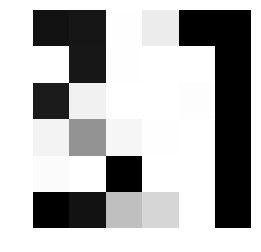

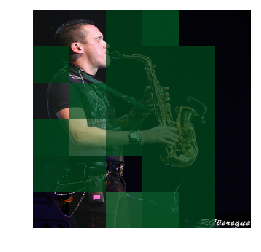

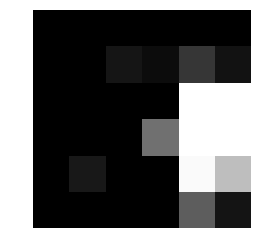

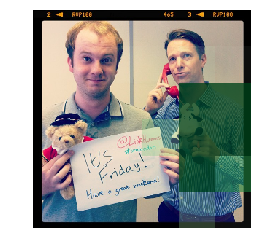

In [9]:
image_height=image_size
image_width=image_size

occ_height=50
occ_width=50

occlusion=np.ndarray(shape=(occ_height,occ_width))
heatmap=np.zeros((batch_size, image_height, image_width),dtype=np.uint8)
 
    
ite_height=image_height-occ_height
ite_width=image_width-occ_width

for i in range(0, image_height, occ_height):
    for j in range(0, image_width, occ_width):
        print("Region: ", i, j)
        im_occ=np.array(images, copy=True)

        occ_height_end=min(image_height,i+occ_height)
        occ_width_end=min(image_width,j+occ_width)

        im_occ[:,i:occ_height_end,j:occ_width_end,:]=255
     
        probs, _ = calc_probs(im_occ)
        pred_probability=[]
        for b in range(probs.shape[0]):
            pred_probability.append(probs[b][actual_class_index[b]])
        print("probabilities: ", actual_probability, pred_probability)
        
        
        for k in range(images.shape[0]):    
            heatmap[k, i:occ_height_end,j:occ_width_end] = (abs(actual_probability[k]-pred_probability[k]))*255
            
        
cmap_overlay = plt.cm.Greens
cmap_overlay._init()
cmap_overlay._lut[:,-1] = np.linspace(0, 0.8, 259)

for l in range(batch_size):
    
    plt.imshow(heatmap[l].astype(np.uint8), cmap='gray')
    plt.axis('off')
    plt.show() 
    
    plt.imshow(images[l].astype(np.uint8))
    plt.imshow(heatmap[l].astype(np.uint8), cmap = cmap_overlay)
    plt.axis('off')
    plt.show()
        

